In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101
# from tensorflow.keras.applications import Xception
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#It should be 
from tensorflow.keras.layers import Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn import preprocessing
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from zipfile import ZipFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Spectrogram For Train Test/Heavy Cough Cov-Non Cov'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
disease_types = ['Covid', 'Non Covid']

train_dir = data_dir = '/content/drive/MyDrive/Spectrogram For Train Test/Heavy Cough Cov-Non Cov'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
pd.set_option('display.max_columns', None) 
train.tail(12)

,File,ID,Disease Type
1386,Non Covid/DZmX1dGK8KdmY3WYQFuCXrVWuhk2_cough-h...,1,Non Covid
1387,Non Covid/T6a1ltY6OiOg38ChVI4URNFmGe23_cough-h...,1,Non Covid
1388,Non Covid/SopKRSJ4JcY36rGE8X4wRE7vPHl2_cough-h...,1,Non Covid
1389,Non Covid/PZhCH5PyO8RD2FPFQbeCmuGB5q33_cough-h...,1,Non Covid
1390,Non Covid/BPQxhBSlypXZICqfsmZcUYBxFmz1_cough-h...,1,Non Covid
1391,Non Covid/MVhuzBxevwRieaQMwOCfiyCCzUK2_cough-h...,1,Non Covid
1392,Non Covid/I5gTlFVoKbVFGCKxwV6QXSOdkZN2_cough-h...,1,Non Covid
1393,Non Covid/FYXJ3Brvf1Wi8YdILInJ19dSiJM2_cough-h...,1,Non Covid
1394,Non Covid/IBjSkzn7W6WpVSw49EXPM2ME75t2_cough-h...,1,Non Covid
1395,Non Covid/6BGTwwcsLoZpqSMhSzFeT2Z7Pqr2_cough-h...,1,Non Covid


In [ ]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X = X / 255.
print(X.shape)

1398it [30:15,  1.30s/it]


(1398, 224, 224, 3)


In [ ]:
y = train['ID'].values
#y_train = to_categorical(y_train, num_classes=2)
print(y)

[0 0 0 ... 1 1 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# print ("Shape of an image in X_train: ", X_train[0].shape)
# print ("Shape of an image in X_test: ", X_test[0].shape)

In [ ]:

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy={'c': 400},random_state=42)
X_train= np.array(X_train)
X_resampled, y_resampled = sm.fit_resample(X_train.reshape(X_train.shape[0], -1), np.array(y_train))
X_resampled = X_resampled.reshape(-1, 224, 224, 3)
X_train,y_train=X_resampled, y_resampled

In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 

In [ ]:
BATCH_SIZE =25
EPOCHS = 25
SIZE = 224
N_ch=3

In [ ]:
from keras.applications import vgg16
def build_VGG16():
    # img_rows, img_cols = 150, 150  #image shape = 224 X 224
    img_rows, img_cols = 224 , 224

    vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, 
              input_shape = (img_rows, img_cols, 3)) # image net has more neurons but we have only 2 hence we are not using the top layer

    # Here we freeze the last 4 layers 
    # Layers are set to trainable as True by default
    for layer in vgg.layers:
      layer.trainable = False  # just copies the weights 
    
    # Let's print our layers 
    for (i,layer) in enumerate(vgg.layers):
      print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    
    return vgg

In [ ]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dense(512,activation='relu')(top_model)
    #top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model 

In [ ]:
model = build_VGG16()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('vgg16_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

58889256/58889256 [==============================] - 2s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

num_classes = 3
FC_Head = lw(model, num_classes)
model = Model(inputs = model.input, outputs = FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.models import Model
# model.add(Conv2D(kernel_size=(3,3),filters=128,input_shape=(150, 150, 3),activation="relu",padding="valid"))
# model.add(Conv2D(kernel_size=(3,3),filters=64,input_shape=(150, 150, 3),activation="relu",padding="valid"))
optimizer = SGD(lr=0.000001,  decay=0.0)

# optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
print(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(y_train.shape[0],y_train.shape[1])


838 224 224 3
838 3


In [ ]:
X_train.shape[0]
history= model.fit(tf.expand_dims(X_train, axis=-1),y_train,batch_size=BATCH_SIZE,steps_per_epoch=10,epochs=EPOCHS, verbose=1, callbacks=[annealer, checkpoint],validation_data=(X_test, y_test))

# history = model.fit(datagen.flow(tf.expand_dims(X_train, axis=-1), y_train, batch_size=BATCH_SIZE),
#                steps_per_epoch=10,
#                epochs=EPOCHS,
#                verbose=1,
#                callbacks=[annealer, checkpoint],
#                validation_data=(X_test, y_test))

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.9200
Epoch 1: val_loss improved from inf to 0.77510, saving model to vgg16_Model.hdf5
10/10 [==============================] - 15s 673ms/step - loss: 0.7944 - accuracy: 0.9200 - val_loss: 0.7751 - val_accuracy: 0.9070 - lr: 1.0000e-06
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.8960
Epoch 2: val_loss improved from 0.77510 to 0.77460, saving model to vgg16_Model.hdf5
10/10 [==============================] - 4s 459ms/step - loss: 0.7678 - accuracy: 0.8960 - val_loss: 0.7746 - val_accuracy: 0.9106 - lr: 1.0000e-06
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.9080
Epoch 3: val_loss improved from 0.77460 to 0.77412, saving model to vgg16_Model.hdf5
10/10 [==============================] - 4s 469ms/step - loss: 0.8148 - accuracy: 0.9080 - val_loss: 0.7741 - val_accuracy: 0.9106 - lr: 1.0000e-06
Epoch 4/25
10/10 [====

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



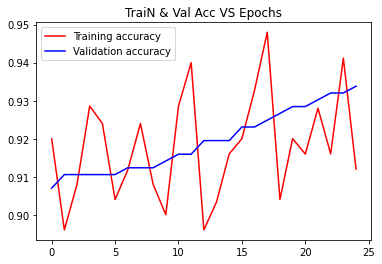

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()



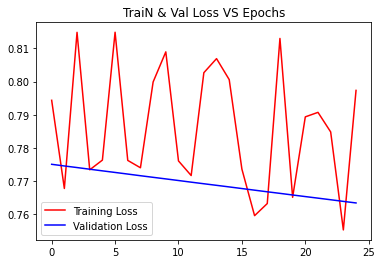

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
model.load_weights("vgg16_Model.hdf5")
model.save('/content/drive/MyDrive/Model Saves/VGG16 Heavy Cough')
score = model.evaluate(X_test,y_test ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

18/18 [==============================] - 7s 234ms/step - loss: 0.7635 - accuracy: 0.9338
Test Loss: 0.7634615302085876
Test accuracy: 93.38103532791138


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

pred = model.predict(X_test)
rounded_labels_1 = np.argmax(pred, axis=1)
rounded_labels_2 = np.argmax(y_test, axis=1)
rounded_labels_1[1]
rounded_labels_2[1]
accuracy_score(rounded_labels_2,rounded_labels_1)
confusion_matrix(rounded_labels_2,rounded_labels_1)
print(classification_report(rounded_labels_2,rounded_labels_1))

18/18 [==============================] - 3s 138ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.96      0.97      0.97       539
           2       0.00      0.00      0.00         0

    accuracy                           0.93       559
   macro avg       0.32      0.32      0.32       559
weighted avg       0.93      0.93      0.93       559



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1